In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim

import time

## some examples of how to read data and downsize

In [3]:
hdulist = fits.open('/Volumes/NO NAME/Maps/Om0.183_si0.958/WLconv_z1.00_0001r.fits')  # <-- Gemma's testing file path
#hdulist = fits.open('/Volumes/WTL/convergence_maps/Om0.183_si0.958/WLconv_z1.00_0001r.fits')  # <-- Tianli's testing file path
hdulist.info()

Filename: /Volumes/NO NAME/Maps/Om0.183_si0.958/WLconv_z1.00_0001r.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (1024, 1024)   float32   


In [4]:
hdudata = hdulist[0]
data = hdudata.data 

In [5]:
hdudata.shape

(1024, 1024)

In [6]:
hdudata.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
EXTEND  =                    T                                                  
ANGLE   =                  3.5 / angle of the map in degrees                    

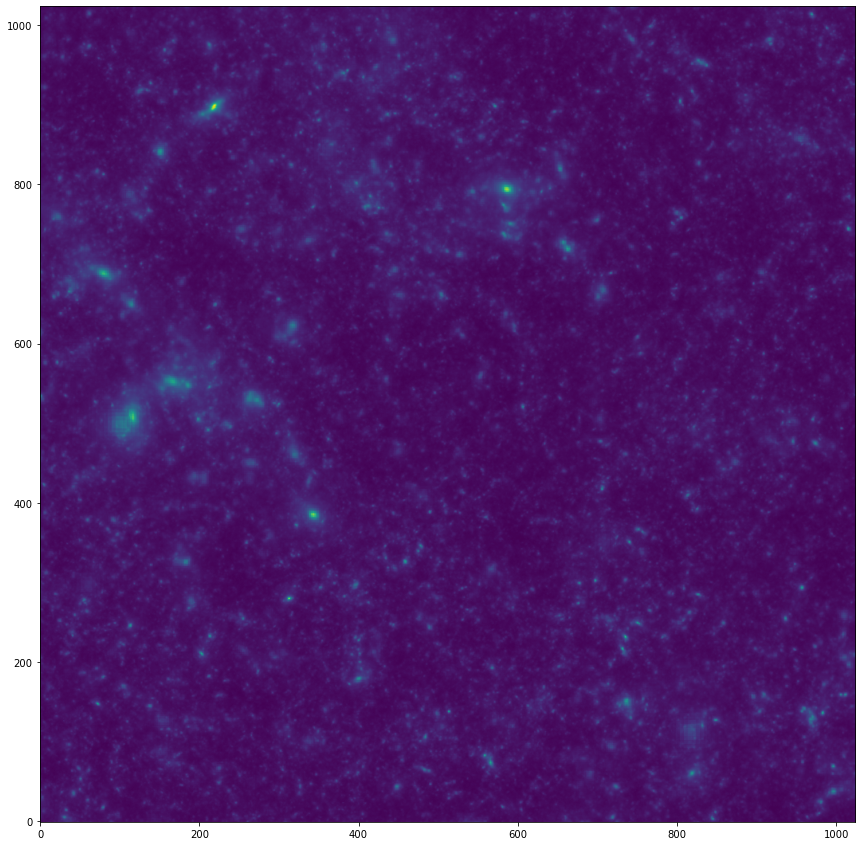

In [7]:
matplotlib.rcParams['figure.figsize'] = [15, 15]  # just to change the plot size when we need to (here only trying to see how the size of the structures on the map compare to the pixel size after downsizing two cells later)
plt.imshow(hdudata.data, origin='lower')

In [8]:
# example of how to downsize 

l_original = int(data.shape[0])
l_downsized = int(l_original/2)
image_downsized = data.reshape([l_downsized, l_original//l_downsized, 
                                l_downsized, l_original//l_downsized]).mean(3).mean(1)
l_downsized_2 = int(l_original/4)
image_downsized_2 = data.reshape([l_downsized_2, l_original//l_downsized_2, 
                                l_downsized_2, l_original//l_downsized_2]).mean(3).mean(1)

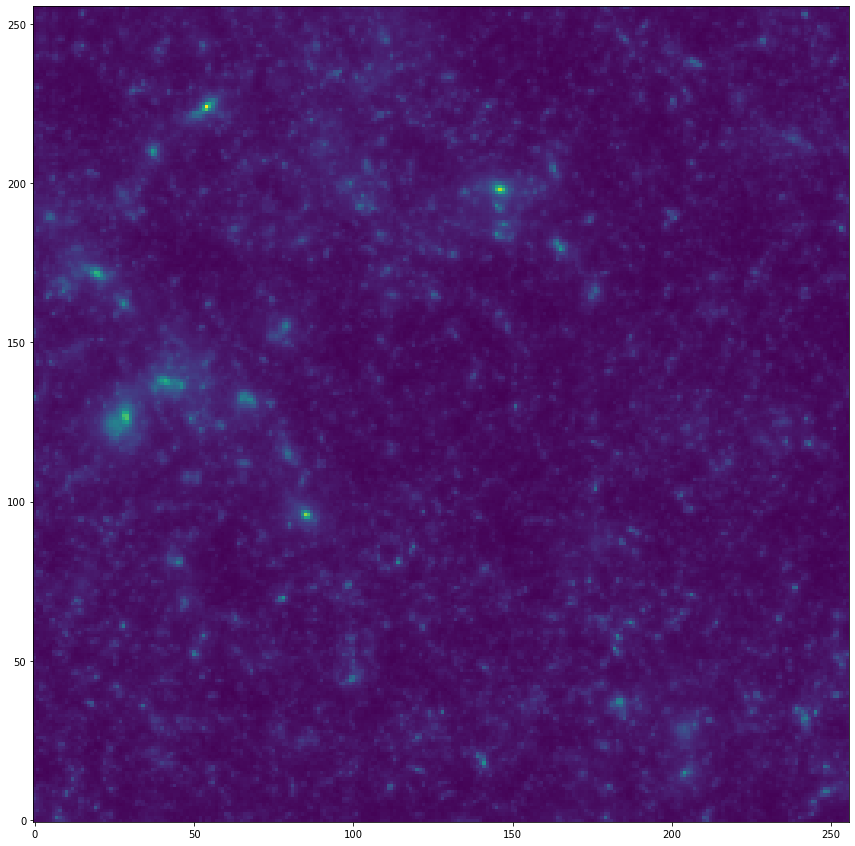

In [9]:
plt.imshow(image_downsized_2, origin='lower')

## Actual code for the network starts below

In [32]:
# define constants etc.  

# add your file path into rootpath before you proceed 
#rootpath = '/Volumes/WTL/convergence_maps/'  # <-- Tianli's testing file path
rootpath = '/Volumes/NO NAME/Maps/'  # <-- Gemma's testing file path

# cosmology parameters for images 
omegam = 0.183
sigma8 = 0.958

# these parameters are inherent to the image data 
n_epoch = 2      # number of epochs to run 
n_imagespercosmo = 512  # number of images per cosmology 
n_perbatch = 32         # batch size
n_batch = n_imagespercosmo/n_perbatch  # number of minibatches 
dim_image = 1024 
dim_downsized = int(dim_image/2)            # downsized image dimension 

learning_rate = 0.005

In [33]:
def read_files(path, Om, si, i_start, i_end): 
    '''
    Input: file root directory path, omegam and sigma8 values, 
    start image index and end image index 
    
    Function: reads the images labeled between i_start and i_end (inclusive)
    for the cosmology specified by omegam and sigma8
    
    Output: images in numpy array of 3D images
    '''
    
    # read in the files and put them into 3D matrix 
    filedata = []

    start_time = time.time()  # time loading files

    for i in range(i_start, i_end+1): 
        if (i < 10): filenum = '00{}'.format(i)
        elif (i < 100): filenum = '0{}'.format(i)
        else: filenum = i 
    
        hdulist = fits.open('{}Om{}_si{}/WLconv_z1.00_0{}r.fits'.format(rootpath, Om, si, filenum))
        image = hdulist[0].data
    
        # downsize from dim_image to dim_downsized 
        image_downsized = image.reshape([dim_downsized, dim_image//dim_downsized, 
                                dim_downsized, dim_image//dim_downsized]).mean(3).mean(1)
    
        # newaxis makes the image 3D (1x512x512) 
        filedata.append(image_downsized[np.newaxis,:,:])

    print("--- Time to load the files: %s seconds ---" % (time.time() - start_time))
    
    return np.array(filedata)

In [36]:
def reset_network(network):
    '''
    Input: CNN object 
    
    Function: resetting the parameters in all the layers of network 
    '''
    for layer in network.children():     
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [34]:
inputs = read_files(rootpath, omegam, sigma8, 1, n_imagespercosmo)

--- Time to load the files: 101.50243210792542 seconds ---


In [16]:
# break the data into batches  

#n_perbatch = 5  # this is a temp testing value to replace the default 32 per batch
target = torch.tensor([Om, si]).repeat(n_perbatch, 1)  # target value of sigma8 and omegam (stacked to the correct dimension to match the number per batch)

# make the data into 4D tensor and put each batch into iterable 
trainloader = torch.utils.data.DataLoader(inputs, batch_size=n_perbatch, shuffle=False)

In [18]:
# network structure 

class Net (nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool2 = nn.AvgPool2d(2, 2)
        self.pool4 = nn.AvgPool2d(4, 4)
        self.pool6 = nn.AvgPool2d(6, 6)
        
        self.conv1to32_5 = nn.Conv2d(1, 32, 5)
        self.conv32to64_5 = nn.Conv2d(32, 64, 5)
        self.conv64to128_5 = nn.Conv2d(64, 128, 5)
        self.conv128to256_5 = nn.Conv2d(128, 256, 5)
        self.conv256to512_5 = nn.Conv2d(256, 512, 5)
        self.conv512to256_5 = nn.Conv2d(512, 216, 5)
        self.conv256to512_3 = nn.Conv2d(216, 512, 3)
        
        self.fc = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool2(F.relu(self.conv1to32_5(x)))  # out: 254x254x32 
        x = self.pool2(F.relu(self.conv32to64_5(x)))  # out: 125x125x64 
        x = self.pool2(F.relu(self.conv64to128_5(x)))  # out: 60x60x128 
        x = self.pool2(F.relu(self.conv128to256_5(x)))  # out: 28x28x256 
        x = self.pool2(F.relu(self.conv256to512_5(x)))  # out: 12x12x512
        x = F.relu(self.conv512to256_5(x))  # out: 8x8x256 
        x = self.pool6(F.relu(self.conv256to512_3(x)))  # out: 6x6x512->1x1x512
        
        x = x.view(-1, 512)
        x = self.fc(x)
        return x
    
net = Net()

In [19]:
# loss function and training rate defined by paper 
criterion = nn.L1Loss()  # MAE loss 
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

In [20]:
start_time = time.time()  # to time the training

for epoch in range(n_epoch): 
    #running_loss = 0.0 
    
    for i, data in enumerate(trainloader, 0):  
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        # .item() converts the tensor to a numpy number
#        running_loss += loss.item()
         
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))   # Changed running_loss to loss.item()  (1101w)

print("--- Training time: %s seconds ---" % (time.time() - start_time))

[1,     1] loss: 0.561
[1,     2] loss: 0.557
[1,     3] loss: 0.554
[1,     4] loss: 0.551
[1,     5] loss: 0.548
[1,     6] loss: 0.544
[1,     7] loss: 0.541
[1,     8] loss: 0.538
[1,     9] loss: 0.535
[1,    10] loss: 0.532
[1,    11] loss: 0.528
[1,    12] loss: 0.525
[1,    13] loss: 0.522
[1,    14] loss: 0.519
[1,    15] loss: 0.515
[1,    16] loss: 0.512
[2,     1] loss: 0.509
[2,     2] loss: 0.506
[2,     3] loss: 0.503
[2,     4] loss: 0.499
[2,     5] loss: 0.496
[2,     6] loss: 0.493
[2,     7] loss: 0.490
[2,     8] loss: 0.487
[2,     9] loss: 0.483
[2,    10] loss: 0.480
[2,    11] loss: 0.477
[2,    12] loss: 0.474
[2,    13] loss: 0.471
[2,    14] loss: 0.467
[2,    15] loss: 0.464
[2,    16] loss: 0.461
--- Training time: 2256.695914030075 seconds ---


"\nfor layer in net.children():     # resetting the parameters in all the layers\n   if hasattr(layer, 'reset_parameters'):\n       layer.reset_parameters()\n"

## Testing the NN

In [35]:
n_testimages = 64 

# use for the first n_testimages images in the same cosmology for now 
inputs_test = inputs[:n_testimages]

# target is still the same as training target  
# target = torch.tensor([Om, si]).repeat(n_perbatch, 1)  # target value of sigma8 and omegam

# make the data into 4D tensor and put each batch into iterable 
testloader = torch.utils.data.DataLoader(np.array(inputs_test), batch_size=n_perbatch, shuffle=False)
test_iterable = iter(testloader)

In [30]:
with torch.no_grad(): 
    for i, data_test in enumerate(testloader, 0):
        outputs_test = net(data_test)
        print(outputs_test[0])
        loss = criterion(outputs_test, target)
        print("Loss: ", loss.item())

tensor([0.0868, 0.1386])
Loss:  0.4577922224998474
tensor([0.0868, 0.1386])
Loss:  0.45779186487197876
